# Exercise Sheet 5 Solution (from Exercise4.tex)

This notebook provides solutions to the exercises in `Exercise4.tex` (which is titled Exercise Sheet 5 internally).

# Exercise 1: Basic Attention Visualization

## 1. Setup environment and load model

First, ensure you have the necessary libraries installed. You can run the following command in your terminal or in a notebook cell by prefixing it with `!`:

In [1]:
# !pip install bertviz transformers torch
# Note: Ensure you have PyTorch installed as well.
# For version consistency as mentioned in troubleshooting (from Exercise4.tex):
# !pip install transformers==4.25.1 bertviz==1.0.0 torch

Import necessary modules and load the pre-trained BERT model and tokenizer.
We set `output_attentions=True` to get attention weights from the model.

In [2]:
from bertviz import head_view
from transformers import BertModel, BertTokenizer
import torch

# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
try:
    model = BertModel.from_pretrained(model_name, output_attentions=True)
    tokenizer = BertTokenizer.from_pretrained(model_name)
except Exception as e:
    print(f"Error loading model/tokenizer: {e}")
    print("If you are facing version conflicts, try pinning versions as per the exercise sheet:")
    print("transformers==4.25.1, bertviz==1.0.0")
    # As a fallback for CUDA memory issues, if applicable (model from exercise sheet):
    # model_name = 'google/bert_uncased_L-2_H-128_A-2' # bert-tiny, though exercise says 'bert-tiny' which is less specific
    # model = BertModel.from_pretrained(model_name, output_attentions=True)
    # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # Tiny often uses base tokenizer
    raise e

# Prepare input text
text = "The cat sat on the mat because it was tired."
inputs_tokenized = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs_tokenized['input_ids']

# Get model outputs
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculations for inference
    outputs = model(input_ids=input_ids, attention_mask=inputs_tokenized['attention_mask'])

# attentions is a tuple of torch.FloatTensor (one for each layer) of shape
# (batch_size, num_heads, sequence_length, sequence_length)
attention_bertviz = outputs.attentions # Using .attentions from BertModelOutput

# Convert input IDs to tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Visualize attention using head_view
print("Visualizing attention heads. This might take a moment to render.")
# Ensure you are in a Jupyter environment for head_view to render correctly.
# If it doesn't render, the troubleshooting tip is to run in a Jupyter notebook directly.
head_view(attention_bertviz, tokens)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Visualizing attention heads. This might take a moment to render.


<IPython.core.display.Javascript object>

## 3. Tasks:

The `head_view` visualization above will open in a new tab or be embedded in the notebook if run in Jupyter Lab/Notebook. Use this interactive visualization to answer the following:

### a) Identify attention heads focusing on pronouns ("it")

**How to approach:**
In the `head_view` visualization:
1.  Select different layers and attention heads using the controls.
2.  Observe the attention patterns for the token "it".
3.  Look for heads where "it" strongly attends to other tokens (e.g., "cat", "mat") or where other tokens strongly attend to "it".
4.  Note down the layer and head numbers that show interesting patterns related to "it". For example, a head might link "it" to its referent "cat" or "mat".

**Example observation (you'll need to verify this with your visualization):**
"In Layer X, Head Y, the token 'it' strongly attends to 'cat', suggesting the model might be resolving the pronoun."

### b) Compare patterns in early vs. final layers

**How to approach:**
1.  In `head_view`, systematically explore attention patterns in early layers (e.g., Layer 0, 1, 2) and compare them with patterns in final layers (e.g., Layer 9, 10, 11 for bert-base).
2.  **Early layers** often capture more local, syntactic relationships (e.g., word-to-next-word, delimiter focusing).
3.  **Final layers** tend to capture more global, semantic, and task-specific relationships.
4.  Describe the differences you observe. For instance, early layers might show diagonal patterns (attending to nearby tokens), while later layers might show more complex, long-range dependencies.

**Example observation:**
"Early layers (e.g., Layer 0-3) predominantly show attention to adjacent tokens and special tokens like [SEP]. In contrast, later layers (e.g., Layer 8-11) exhibit more distributed attention, with some heads focusing on semantically related words across the sentence, such as linking 'tired' back to 'cat' or 'it'."

### c) Find heads specializing in syntactic vs semantic relationships

**How to approach:**
This builds on the previous task.
1.  **Syntactic Heads:** Look for heads that consistently focus on:
    *   Delimiters or sentence structure (e.g., attending to periods, commas, or [SEP] tokens).
    *   Specific parts of speech (e.g., a head where verbs attend to their subjects/objects, though this is harder to verify without POS tagging).
    *   Positional information (e.g., attending to the previous or next token, diagonal patterns).
2.  **Semantic Heads:** Look for heads that:
    *   Link co-referent mentions (e.g., pronouns to nouns).
    *   Connect semantically similar or related words, even if they are distant in the sentence.
    *   Aggregate information broadly, where the [CLS] token attends to important words in the sentence.

**Example observation:**
"Layer L, Head H appears to be a syntactic head, as it consistently makes tokens attend to the subsequent token. Another head, Layer L', Head H', seems more semantic, as it links 'mat' to 'sat on' and 'it' (pronoun) to 'cat' (antecedent)."

# Exercise 2: Feature Attribution with Captum

**Resources:** The exercise sheet links to the [Captum BERT Tutorial](https://captum.ai/tutorials/Bert_SQUAD_Interpret), which is a good reference for more advanced usage.

For this exercise, we'll implement Integrated Gradients to understand feature importance.
The original BERT model (`BertModel`) outputs hidden states and attentions, not a single scalar output suitable for direct classification-style attribution. To use Integrated Gradients effectively, we typically need a scalar output from our model (e.g., a specific logit for a class, or a score).

Here, we'll define a simple `forward_func` that takes input embeddings and returns a scalar value derived from the model's `pooler_output` (which is based on the [CLS] token's representation). We will then compute attributions with respect to the input embeddings.

In [3]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model, tokenizer, input_ids, inputs_tokenized are available from Exercise 1

# 1. Define a forward function for Captum.
# This function should take input embeddings and return a scalar output per batch item.
def model_forward_for_captum(inputs_embeds, attention_mask_captum):
    outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask_captum)
    # pooler_output is (batch_size, hidden_size)
    # We'll sum the pooler_output to get a scalar value per batch item for attribution.
    return torch.sum(outputs.pooler_output, dim=1)

# 2. Get input embeddings
input_embeddings = model.embeddings(input_ids)

# 3. Initialize IntegratedGradients
ig = IntegratedGradients(model_forward_for_captum)

# 4. Compute attributions
attention_mask_for_captum = inputs_tokenized['attention_mask']
try:
    attributions_ig, delta = ig.attribute(
        input_embeddings,
        additional_forward_args=(attention_mask_for_captum,),
        target=None, # Output is scalar per instance, so no target index needed. # NEW LINE
        n_steps=50,
        return_convergence_delta=True
    )
except Exception as e:
    print(f"Error during IG attribution: {e}")
    print("This might be due to the model architecture or the forward_func definition.")
    print("Ensure the forward_func returns a scalar per batch item or a tensor that can be indexed by 'target'.")
    raise e

# Attributions_ig will have shape (batch_size, seq_len, embedding_dim)
# For visualization, we sum over the embedding dimension to get per-token importance
token_attributions = attributions_ig[0].sum(dim=-1).detach().cpu().numpy()

print("Integrated Gradients Attributions (summed over embedding dimension):")
print(token_attributions)
print("Convergence Delta:", delta.detach().cpu().numpy())

# Get tokens again for labeling plot (same as 'tokens' from Ex1)
tokens_for_plot = tokenizer.convert_ids_to_tokens(input_ids[0])

Integrated Gradients Attributions (summed over embedding dimension):
[-0.04409069 -0.10917497  0.31029284 -1.0926391  -1.065913   -0.14184469
 -0.04294351 -0.07475507 -1.6491933   0.16359091 -3.071321   -9.547855
 24.520378  ]
Convergence Delta: [14.304551]


## Compare with attention weights

Attention weights show how tokens relate to each other. Integrated Gradients (here, on input embeddings) show each token's importance towards the defined model output.
We'll visualize IG attributions (1D per token) and one attention head's output (2D matrix).

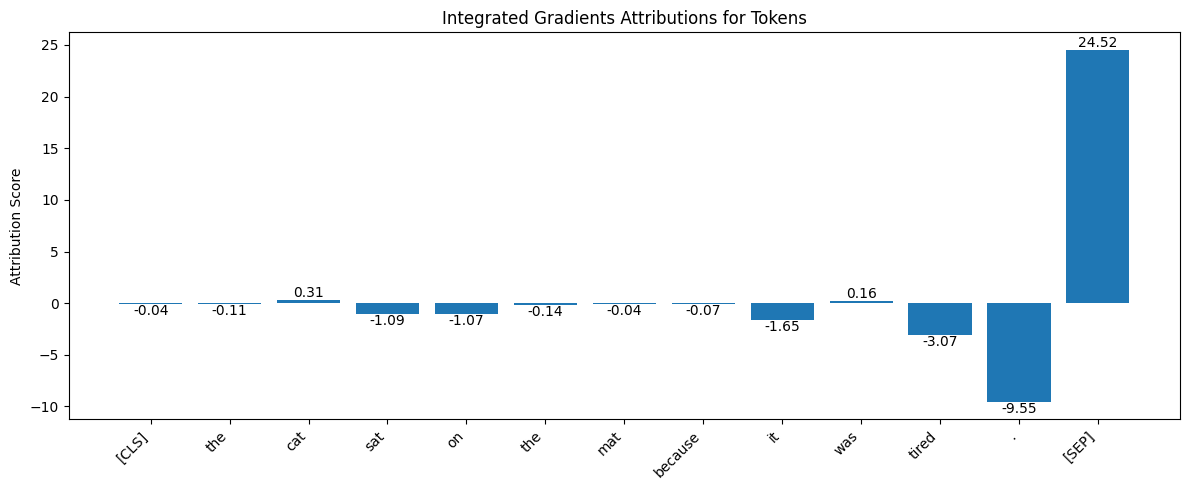

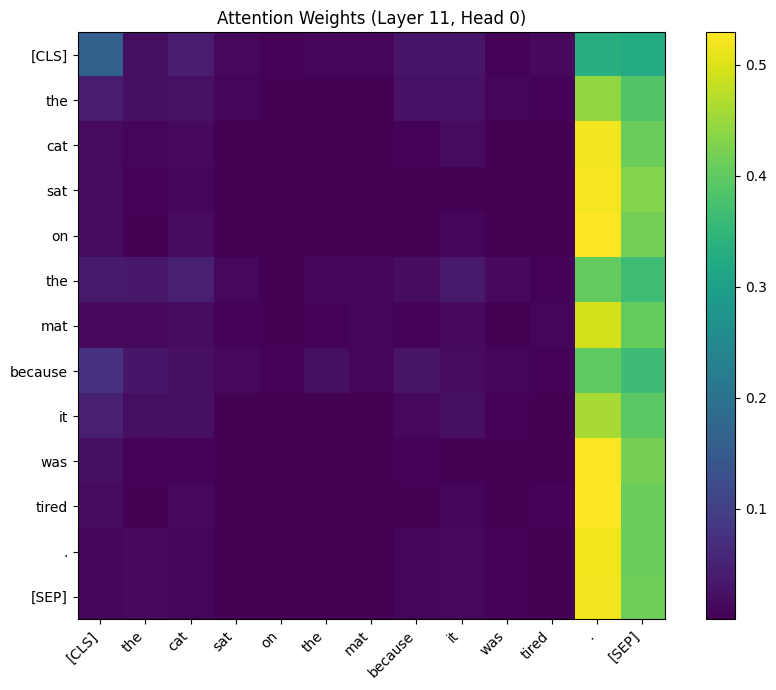

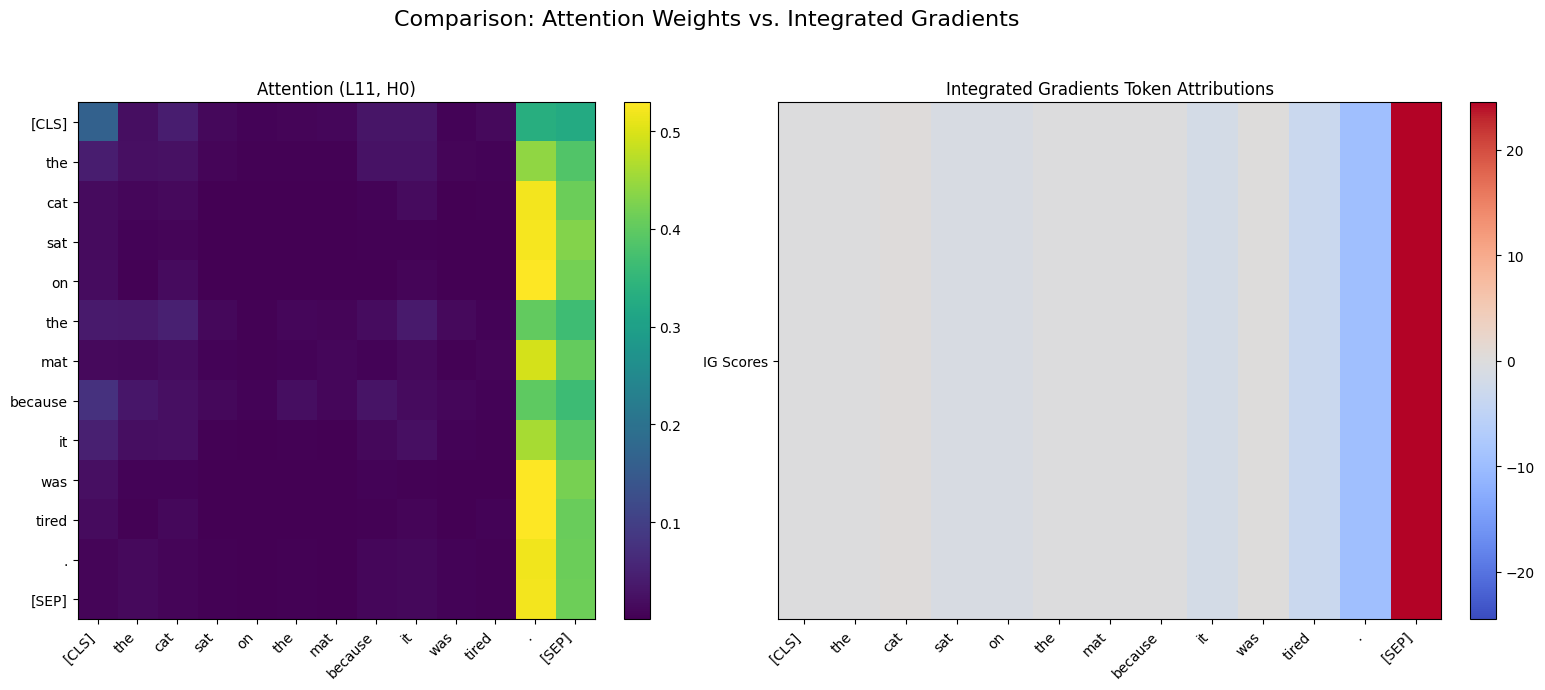

In [4]:
# Visualize IG attributions as a bar chart
fig_ig_bar, ax_ig = plt.subplots(figsize=(12, 5))
x_pos = np.arange(len(tokens_for_plot))
bar_container = ax_ig.bar(x_pos, token_attributions, align='center')
ax_ig.set_xticks(x_pos)
ax_ig.set_xticklabels(tokens_for_plot, rotation=45, ha="right")
ax_ig.set_title('Integrated Gradients Attributions for Tokens')
ax_ig.set_ylabel('Attribution Score')
ax_ig.bar_label(bar_container, fmt='{:.2f}') # Add labels to bars
plt.tight_layout()
plt.show()

# Visualize one attention head (e.g., from the last layer, first head)
layer_to_show = -1  # Last layer
head_to_show = 0    # First head
attention_single_head = attention_bertviz[layer_to_show][0, head_to_show].detach().cpu().numpy()
actual_layer_index = layer_to_show if layer_to_show >= 0 else model.config.num_hidden_layers + layer_to_show

fig_att, ax_att = plt.subplots(figsize=(9, 7))
im = ax_att.imshow(attention_single_head, cmap='viridis')
ax_att.set_xticks(np.arange(len(tokens_for_plot)))
ax_att.set_yticks(np.arange(len(tokens_for_plot)))
ax_att.set_xticklabels(tokens_for_plot, rotation=45, ha="right")
ax_att.set_yticklabels(tokens_for_plot)
ax_att.set_title(f'Attention Weights (Layer {actual_layer_index}, Head {head_to_show})')
fig_att.colorbar(im, ax=ax_att)
plt.tight_layout()
plt.show()

# Side-by-side comparison as suggested by the exercise structure
fig_comp, (ax1_comp, ax2_comp) = plt.subplots(1, 2, figsize=(17, 7))

# Attention plot
im1 = ax1_comp.imshow(attention_single_head, cmap='viridis')
ax1_comp.set_xticks(np.arange(len(tokens_for_plot)))
ax1_comp.set_yticks(np.arange(len(tokens_for_plot)))
ax1_comp.set_xticklabels(tokens_for_plot, rotation=45, ha="right")
ax1_comp.set_yticklabels(tokens_for_plot)
ax1_comp.set_title(f'Attention (L{actual_layer_index}, H{head_to_show})')
fig_comp.colorbar(im1, ax=ax1_comp, fraction=0.046, pad=0.04)

# IG Attributions plot (reshaped for imshow)
im2 = ax2_comp.imshow(token_attributions.reshape(1, -1), cmap='coolwarm', aspect='auto', vmin=-np.abs(token_attributions).max(), vmax=np.abs(token_attributions).max())
ax2_comp.set_yticks([0])
ax2_comp.set_yticklabels(["IG Scores"])
ax2_comp.set_xticks(np.arange(len(tokens_for_plot)))
ax2_comp.set_xticklabels(tokens_for_plot, rotation=45, ha="right")
ax2_comp.set_title('Integrated Gradients Token Attributions')
fig_comp.colorbar(im2, ax=ax2_comp, fraction=0.046, pad=0.04)

plt.suptitle("Comparison: Attention Weights vs. Integrated Gradients", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Theoretical Questions

### 1. How does attention visualization differ from feature attribution?

*   **Attention Visualization (e.g., `bertviz`):**
    *   **What it shows:** Visualizes the internal working of self-attention mechanisms. It shows how much "focus" or "weight" each token gives to other tokens in the sequence when computing its updated representation.
    *   **Scope:** Specific to attention-based models. It's a direct look at a particular component of the model.
    *   **Interpretation:** Can reveal patterns like syntactic dependencies, co-reference, or positional biases learned by attention heads. However, high attention weight doesn't always mean high importance for the final prediction.
    *   **Model-agnosticism:** No, it's model-specific (for attention mechanisms).

*   **Feature Attribution (e.g., Integrated Gradients, LIME, SHAP):**
    *   **What it shows:** Assigns an importance score to each input feature (e.g., token, pixel) indicating how much that feature contributed to a specific model output or prediction.
    *   **Scope:** Can be applied to a wider range of models. It's about the input-output relationship for a specific prediction.
    *   **Interpretation:** Aims to explain *why* the model made a certain prediction by highlighting influential input parts.
    *   **Model-agnosticism:** Some methods are model-agnostic (LIME, SHAP applied to black-box models), while others are model-specific but broadly applicable (gradient-based methods like IG for differentiable models).

**Key Difference:** Attention visualization shows an *internal mechanism* of the model, while feature attribution attempts to explain the *model's decision* by linking input features to a specific output. Attention is one part of the model; feature attribution considers the model (or parts of it) more holistically in relation to a specific output.

### 2. What are the limitations of visualizing attention as explanation?

*   **Correlation vs. Causation:** High attention scores don't necessarily mean a token is causally important for the model's final output. Attention weights are internal scores used to combine information, not direct measures of feature importance for a prediction. (See papers: "Attention is not Explanation" by Jain and Wallace, 2019; and "Attention is not *not* Explanation" by Wiegreffe and Pinter, 2019).
*   **Multiple Layers/Heads:** Transformer models have many attention heads across multiple layers. It's challenging to synthesize a single coherent explanation from all these diverse patterns. Focusing on a single head or layer might be misleading or incomplete.
*   **Post-Attention Processing:** Information passes through feed-forward networks, layer normalization, and residual connections *after* the attention mechanism. These subsequent operations can transform, gate, or combine information in ways that attention patterns alone don't reveal.
*   **Redundancy and Diffuse Attention:** Some heads might be redundant or learn trivial patterns. Attention might also be diffused across many tokens, making it hard to pinpoint specific important relationships without aggregation or filtering.
*   **Not Predictive of Adversarial Perturbations:** Attention patterns may not reliably indicate which tokens, if perturbed, would most significantly change the model's prediction.
*   **Task-Dependence:** The extent to which attention patterns are "explanatory" can vary significantly by task, model architecture, and even training data.

### 3. When would you prefer attention visualization over gradient-based methods?

*   **Understanding Internal Model Mechanics:** If the primary goal is to understand *how* an attention-based model processes information internally, rather than just explaining a single prediction. For example, to debug if attention heads are learning expected linguistic patterns (e.g., syntactic structures) or to study the types of relationships captured at different layers.
*   **Model Development and Probing:** During the development of new attention mechanisms or Transformer architectures, visualizing attention can provide direct insights into whether the mechanism is behaving as intended (e.g., focusing locally, globally, on specific markers).
*   **Hypothesis Generation:** Attention patterns can generate hypotheses about what the model might be learning. These hypotheses can then be tested more rigorously with other methods, including feature attribution or counterfactual analysis.
*   **Scenarios Without a Clear Scalar Output for Attribution:** In some contexts, like unsupervised pre-training or when analyzing representations without a specific downstream task prediction, defining a single, meaningful scalar output for gradient-based attribution can be challenging. Attention is an inherent property of the forward pass, regardless of a specific prediction head.
*   **Simplicity for Its Specific Purpose:** Visualizing attention is a relatively direct look at existing values computed by the model. Gradient-based methods require further computation (backpropagation, potentially multiple forward passes for methods like IG) and careful setup of the attribution target and forward function.
*   **Complementary Insights:** Attention visualization and feature attribution are not mutually exclusive and can be used together. They provide different perspectives: attention shows an internal process, while attribution links inputs to outputs. If an attention head focuses on certain tokens, and feature attribution methods also highlight those tokens as important for a prediction, it strengthens the evidence for their role.

# Advanced Tasks (Bonus)

The exercise sheet (`Exercise4.tex`) mentions these advanced tasks:
*   Modify visualization for multi-head comparison
*   Calculate attention head importance scores
*   Implement custom attention pattern filtering

These are beyond the scope of this basic solution notebook but are interesting directions for further exploration. `bertviz` offers neuron views and model views that can help with some of these. Captum also has methods for layer and neuron attribution (e.g., `LayerConductance`, `NeuronIntegratedGradients`) which can be relevant for assessing head or neuron importance.

# Troubleshooting Tips

Refer to the original `Exercise4.tex` for troubleshooting tips, such as:
*   **If BERTviz doesn't render:** Ensure you are running the code in a Jupyter Notebook or JupyterLab environment, as `head_view` relies on JavaScript for rendering.
*   **For CUDA memory issues:** Reduce model size (e.g., to `bert-tiny` or a smaller BERT variant like `google/bert_uncased_L-2_H-128_A-2` as mentioned in the `.tex` file's troubleshooting section, though `bert-tiny` is a general name for such small models).
*   **Version conflicts:** Pin to `transformers==4.25.1`, `bertviz==1.0.0` as suggested. Ensure PyTorch is also compatible.

# Recommended Resources

Refer to the original `Exercise4.tex` for recommended resources, including:
*   [BERTviz GitHub](https://github.com/jessevig/bertviz)
*   [Captum BERT Tutorial](https://captum.ai/tutorials/Bert_SQUAD_Interpret)
*   [Attention is not Explanation (Jain and Wallace, 2019)](https://arxiv.org/abs/1902.10186)
*   [Attention is Not Not Explanation (Wiegreffe and Pinter, 2019)](https://arxiv.org/abs/1908.04626) (The `.tex` file mentions arXiv:2004.10102, which is by Sarah Wiegreffe, titled "Attention is Not Only Not Explanation...", a follow-up/commentary. Both are relevant to the discussion.)